In [1]:
from config import *
from tqdm import tqdm, trange
import jsonlines
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# batched using threads
from concurrent.futures import ThreadPoolExecutor

In [2]:
meta = 'mmlu'
topics = ['machine_learning',
          'high_school_physics',
          'high_school_world_history',
          'high_school_chemistry',
          'college_biology',
          'high_school_mathematics'
          ]

In [3]:
def read_jsonl(file_path):
    with jsonlines.open(file_path) as reader:
        data = [obj for obj in reader]
    return data

def read_npz(file_path):
    return np.load(file_path)['arr_0']

def get_datasets(meta, topic, model='Mistral-7B-Instruct-v0.2'):
    if meta == 'mmlu':
        train_path = f'datasets/mmlu/{topic}/{model}-train.jsonl'
        test_path = f'datasets/mmlu/{topic}/{model}-test.jsonl'

        train_emb_path = f'datasets/mmlu/{topic}/embedding-train.npz'
        test_emb_path = f'datasets/mmlu/{topic}/embedding-test.npz'

        train_ds, test_ds = read_jsonl(train_path), read_jsonl(test_path)
        train_emb, test_emb = read_npz(train_emb_path), read_npz(test_emb_path)


    elif meta == 'anthropic':
        train_path = f'datasets/anthropic-eval/{topic}/{model}-train.jsonl'
        test_path = f'datasets/anthropic-eval/{topic}/{model}-test.jsonl'

        train_emb_path = f'datasets/anthropic-eval/{topic}/embedding-train.npz'
        test_emb_path = f'datasets/anthropic-eval/{topic}/embedding-test.npz'

        train_ds, test_ds = read_jsonl(train_path), read_jsonl(test_path)
        train_emb, test_emb = read_npz(train_emb_path), read_npz(test_emb_path)
    
    else:
        raise ValueError(f"Unknown meta: {meta}")
    
    train_ds, test_ds = get_embedding_strs(train_ds, model, meta), get_embedding_strs(test_ds, model, meta)


    return train_ds, test_ds, train_emb, test_emb


no_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D'} #  0-3: A-D, ALL OTHERS: N

def format_single_entry_mmlu(entry, model):
    q, choice, gt, ans = entry['question'], entry['choices'], entry['answer'], entry[model]['answer']

    choice_str = '\n'.join([f'{no_to_letter[i]}: {c}' for i, c in enumerate(choice)])

    return {'question': f'Question: {q}\nChoices:\n{choice_str}', 'correctness' :(gt == ans)}

def format_single_entry_anthropic(entry):
    q = entry['question']
    return q

def get_embedding_strs(ds, model, meta):
    if meta == 'mmlu':
        return [format_single_entry_mmlu(entry, model) for entry in ds]
    elif meta == 'anthropic':
        return [format_single_entry_anthropic(entry, model) for entry in ds]
    else:
        raise ValueError(f"Unknown meta: {meta}")
    
def preprocess_ds(meta, topic, base='Mistral-7B-Instruct-v0.2'):
    train_ds, test_ds = get_datasets(meta, topic, base)
    train_strs, test_strs = get_embedding_strs(train_ds, meta), get_embedding_strs(test_ds, meta)
    return train_strs, test_strs


In [32]:
def plot_tsne(topics, trains, tests):
    # 3 * 2 subplots
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    assert len(topics) == len(trains) == len(tests) == 6

    for i in range(len(topics)):
        tsne = TSNE(n_components=2, random_state=0)
        labels = np.array([0]*len(trains[i]) + [1]*len(tests[i]))
        X_2d = tsne.fit_transform(np.concatenate([trains[i], tests[i]], axis=0))
        target_ids = range(len(labels))
        colors = ['tab:blue', 'tab:orange']
        correctness = ['Train', 'Test']
        for k, c in zip(target_ids, colors):
            axs[i%2, i//2].scatter(X_2d[labels == k, 0], X_2d[labels == k, 1], c=c, label=correctness[k])
        
        # title of topic 
        axs[i%2, i//2].set_title(topics[i])
        # axs[i%2, i//2].legend()
    plt.legend()
    plt.savefig('Plots/tsne_all.png', dpi=600)
    plt.show()

In [33]:
def plot_tsne_seperability(topics, models, tests, labels_cat):
    # 3 * 2 subplots
    fig, axs = plt.subplots(len(models), len(topics), figsize=(16, 16))

    # assert len(topics) == len(labels) == len(tests) == 6

    for j in range(len(models)):
        for i in range(len(topics)):
            tsne = TSNE(n_components=2, random_state=0)
            labels = labels_cat[j][i]
            X_2d = tsne.fit_transform(tests[j][i])
            target_ids = range(len(labels))
            colors = ['tab:blue', 'tab:orange']
            correctness = ['Incorrect', 'Correct']
            for k, c in zip(target_ids, colors):
                axs[j, i].scatter(X_2d[labels == k, 0], X_2d[labels == k, 1], c=c, label=correctness[k])
                # axs[j, i].legend()

    # Set label on the top, called topic
    for i in range(len(topics)):
        axs[0, i].set_title(topics[i])
    # Set label on the left, called model
    for j in range(len(models)):
        axs[j, 0].set_ylabel(models[j])
    plt.savefig('Plots/tsne_tf.png', dpi=600)
    plt.legend()
    plt.show()

In [34]:
trains, tests = [], []
for topic in topics:
    _, _, train_emb, test_emb = get_datasets(meta, topic)
    trains.append(train_emb)
    tests.append(test_emb)

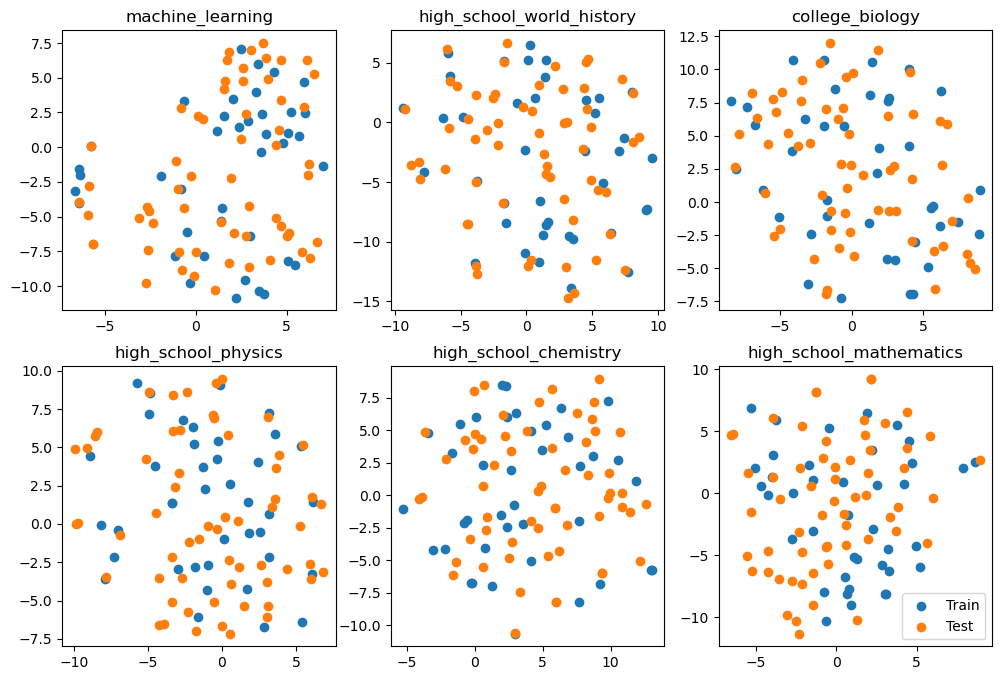

In [35]:
plot_tsne(topics, trains, tests)

In [36]:
models = ['Mistral-7B-Instruct-v0.2',
          'Mixtral-8x7B-Instruct-v0.1',
          'Llama-2-13b-chat-hf',
          'Llama-2-70b-chat-hf',
          'gpt-3.5-turbo-1106']

In [37]:
all_tests, all_labels = [], []
for model in models:
    tests, labels = [], []
    for topic in topics:
        _, test_data, _, test_emb = get_datasets(meta, topic, model)
        test_labels = np.array([entry['correctness'] for entry in test_data], dtype=np.int32)
        labels.append(test_labels)
        tests.append(test_emb)
    all_tests.append(tests)
    all_labels.append(labels)

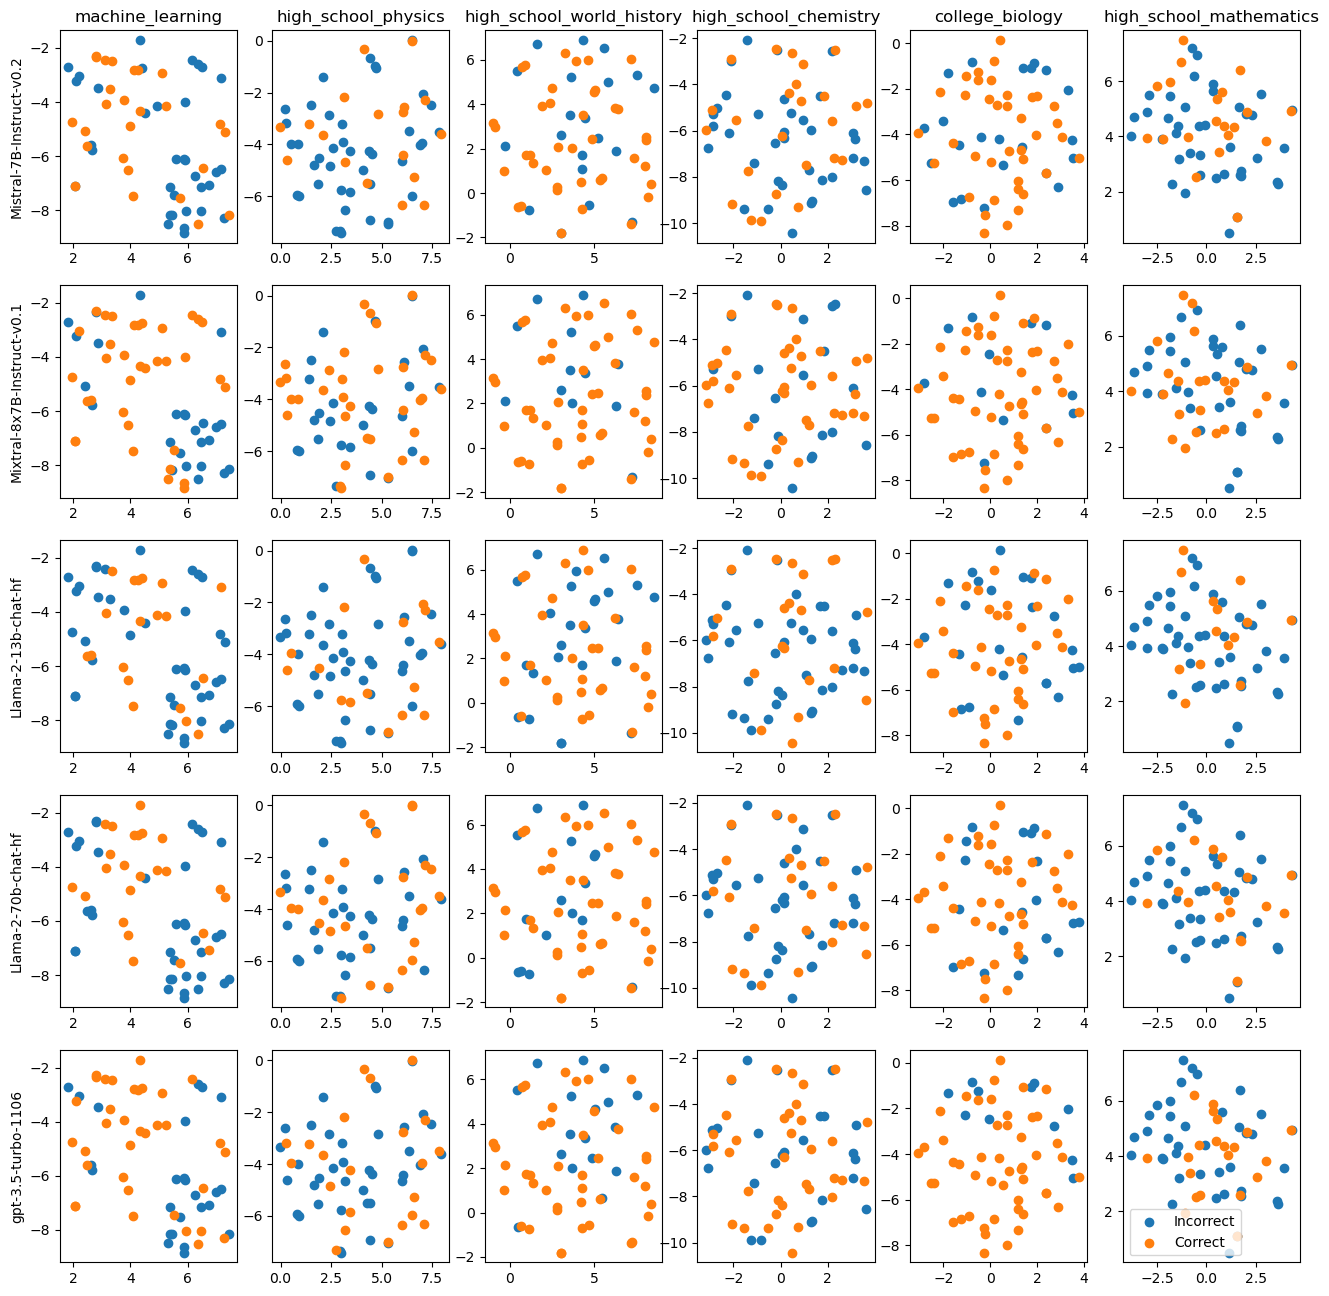

In [38]:
plot_tsne_seperability(topics, models, all_tests, all_labels)

In [81]:
import pandas as pd
import numpy as np
# Load the first dataset into a DataFrame
df1 = pd.DataFrame({
    'Topic': ['high_school_math', 'high_school_math', 'high_school_math', 'high_school_physics', 'high_school_physics', 'high_school_physics', 'college_biology', 'college_biology', 'college_biology', 'high_school_chemistry', 'high_school_chemistry', 'high_school_chemistry', 'high_school_chemistry', 'machine_learning', 'machine_learning', 'machine_learning'],
    'Student Model': ['Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf', 'Mixtral-8x7B-Instruct-v0.1', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf', 'Mixtral-8x7B-Instruct-v0.1', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf', 'Mixtral-8x7B-Instruct-v0.1', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf', 'Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf', 'Mixtral-8x7B-Instruct-v0.1'],
    'Oracle': [0.77, 0.7, 0.6, 0.73, 0.55, 0.57, 0.6, 0.67, 0.8, 0.65, 0.6, 0.67, np.nan, 0.68, 0.6, 0.58],
    'Few-shot': [0.72, 0.6, 0.63, 0.67, 0.45, 0.55, 0.45, 0.6, 0.75, 0.58, 0.42, 0.63, 0.57, 0.72, 0.6, 0.52],
    'One-shot': [0.77, 0.77, 0.67, 0.38, 0.62, 0.65, 0.68, 0.68, 0.82, 0.53, 0.62, 0.73, 0.72, 0.47, 0.67, 0.73]

})

# Load the second dataset into a DataFrame
df2 = pd.DataFrame({
    'topic': ['machine_learning', 'high_school_physics', 'high_school_world_history', 'high_school_chemistry', 'college_biology', 'high_school_mathematics', 'machine_learning', 'high_school_physics', 'high_school_world_history', 'high_school_chemistry', 'college_biology', 'high_school_mathematics', 'machine_learning', 'high_school_physics', 'high_school_world_history', 'high_school_chemistry', 'college_biology', 'high_school_mathematics', 'machine_learning', 'high_school_physics', 'high_school_world_history', 'high_school_chemistry', 'college_biology', 'high_school_mathematics', 'machine_learning', 'high_school_physics', 'high_school_world_history', 'high_school_chemistry', 'college_biology', 'high_school_mathematics'],
    'model': ['gpt-3.5-turbo-1106', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-1106', 'Llama-2-13b-chat-hf', 'Llama-2-13b-chat-hf', 'Llama-2-13b-chat-hf', 'Llama-2-13b-chat-hf', 'Llama-2-13b-chat-hf', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf', 'Llama-2-70b-chat-hf', 'Llama-2-70b-chat-hf', 'Llama-2-70b-chat-hf', 'Llama-2-70b-chat-hf', 'Llama-2-70b-chat-hf', 'Mistral-7B-Instruct-v0.2', 'Mistral-7B-Instruct-v0.2', 'Mistral-7B-Instruct-v0.2', 'Mistral-7B-Instruct-v0.2', 'Mistral-7B-Instruct-v0.2', 'Mistral-7B-Instruct-v0.2', 'Mixtral-8x7B-Instruct-v0.1', 'Mixtral-8x7B-Instruct-v0.1', 'Mixtral-8x7B-Instruct-v0.1', 'Mixtral-8x7B-Instruct-v0.1', 'Mixtral-8x7B-Instruct-v0.1', 'Mixtral-8x7B-Instruct-v0.1'],
    'oracle_acc': [0.583333333, 0.633333333, 0.716666667, 0.566666667, 0.816666667, 0.65, 0.683333333, 0.733333333, 0.583333333, 0.65, 0.6, 0.766666667, 0.6, 0.55, 0.733333333, 0.6, 0.666666667, 0.7, 0.566666667, 0.7, 0.666666667, 0.583333333, 0.633333333, 0.666666667, 0.583333333, 0.566666667, 0.8, 0.666666667, 0.8, 0.6],
    'model_acc': [0.583333333, 0.366666667, 0.716666667, 0.566666667, 0.816666667, 0.35, 0.316666667, 0.266666667, 0.583333333, 0.35, 0.6, 0.233333333, 0.4, 0.45, 0.733333333, 0.4, 0.666666667, 0.3, 0.433333333, 0.3, 0.666666667, 0.416666667, 0.633333333, 0.333333333, 0.583333333, 0.566666667, 0.8, 0.666666667, 0.8, 0.4],
    'logistic_reg_acc': [0.683333333, 0.366666667, 0.716666667, 0.55, 0.816666667, 0.35, 0.683333333, 0.733333333, 0.583333333, 0.666666667, 0.6, 0.766666667, 0.65, 0.466666667, 0.733333333, 0.583333333, 0.666666667, 0.7, 0.566666667, 0.7, 0.666666667, 0.583333333, 0.633333333, 0.666666667, 0.766666667, 0.566666667, 0.8, 0.683333333, 0.8, 0.6]
})

# Merge the two DataFrames on common columns
merged = pd.merge(df1, df2, how='inner', left_on=['Topic', 'Student Model'], right_on=['topic', 'model'])
# merged = pd.merge(df1, df2, how='inner', left_on=['Topic', 'Student Model'], right_on=['topic', 'model'])

# Drop the redundant columns
# merged = merged.drop(['topic', 'model'], axis=1)

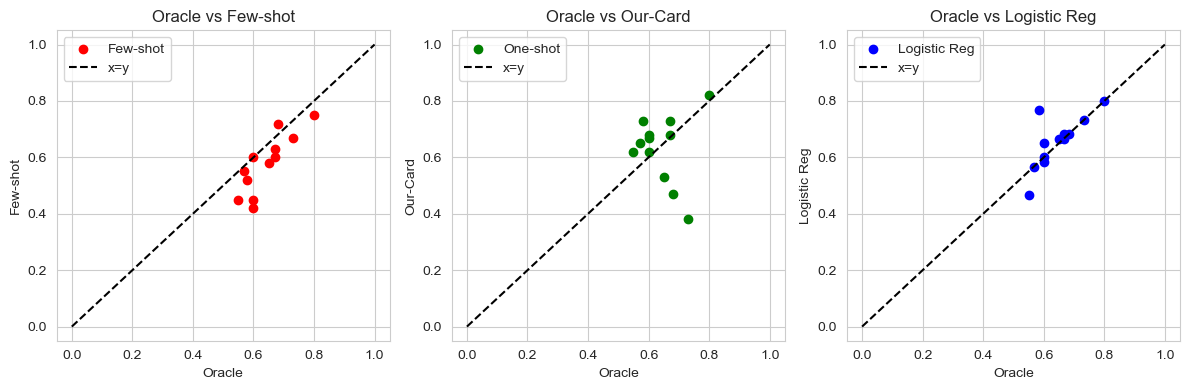

In [82]:
import matplotlib.pyplot as plt

# Set up the figure and axis
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot Oracle vs Few-shot
axs[0].scatter(merged['Oracle'], merged['Few-shot'], color='r', label='Few-shot')
axs[0].plot([0, 1], [0, 1], 'k--', label='x=y')
axs[0].set_xlabel('Oracle')
axs[0].set_ylabel('Few-shot')
axs[0].legend()
axs[0].set_title('Oracle vs Few-shot')

# Plot Oracle vs One-shot 
axs[1].scatter(merged['Oracle'], merged['One-shot'], color='g', label='One-shot')
axs[1].plot([0, 1], [0, 1], 'k--', label='x=y')
axs[1].set_xlabel('Oracle')
axs[1].set_ylabel('Our-Card')
axs[1].legend()
axs[1].set_title('Oracle vs Our-Card')

# Plot Oracle vs Logistic Reg
axs[2].scatter(merged['oracle_acc'], merged['logistic_reg_acc'], color='b', label='Logistic Reg')
axs[2].plot([0, 1], [0, 1], 'k--', label='x=y')
axs[2].set_xlabel('Oracle')
axs[2].set_ylabel('Logistic Reg')
axs[2].legend()
axs[2].set_title('Oracle vs Logistic Reg')

plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('ExpRslts/Predictive_ALL.csv')
df2 = pd.read_csv('results.csv')


merged = pd.merge(df1, df2, how='inner', left_on=['Topic', 'Student_Model'], right_on=['topic', 'model'])

In [38]:
merged.head()

,Student_Model,Topic,Card_Format,Epoch,Predictive_Accuracy,Oracle_Accuracy,Word_Count,Guesser,topic,model,oracle_acc,model_acc,logistic_reg_acc,knn_accuracy
0,Mixtral-8x7B-Instruct-v0.1,high_school_physics,dict,4,0.616667,0.566667,1005,meta-llama/Meta-Llama-3-70B-Instruct,high_school_physics,Mixtral-8x7B-Instruct-v0.1,0.566667,0.566667,0.566667,0.533333
1,Mixtral-8x7B-Instruct-v0.1,high_school_physics,dict,4,0.683333,0.566667,1005,meta-llama/Meta-Llama-3-70B-Instruct,high_school_physics,Mixtral-8x7B-Instruct-v0.1,0.566667,0.566667,0.566667,0.533333
2,Llama-2-70b-chat-hf,high_school_physics,dict,4,0.600000,0.550000,1014,meta-llama/Meta-Llama-3-70B-Instruct,high_school_physics,Llama-2-70b-chat-hf,0.550000,0.450000,0.466667,0.583333
3,Llama-2-13b-chat-hf,high_school_physics,dict,4,0.583333,0.733333,1016,meta-llama/Meta-Llama-3-70B-Instruct,high_school_physics,Llama-2-13b-chat-hf,0.733333,0.266667,0.733333,0.633333
4,Mistral-7B-Instruct-v0.2,high_school_physics,dict,4,0.600000,0.700000,743,meta-llama/Meta-Llama-3-70B-Instruct,high_school_physics,Mistral-7B-Instruct-v0.2,0.700000,0.300000,0.700000,0.466667


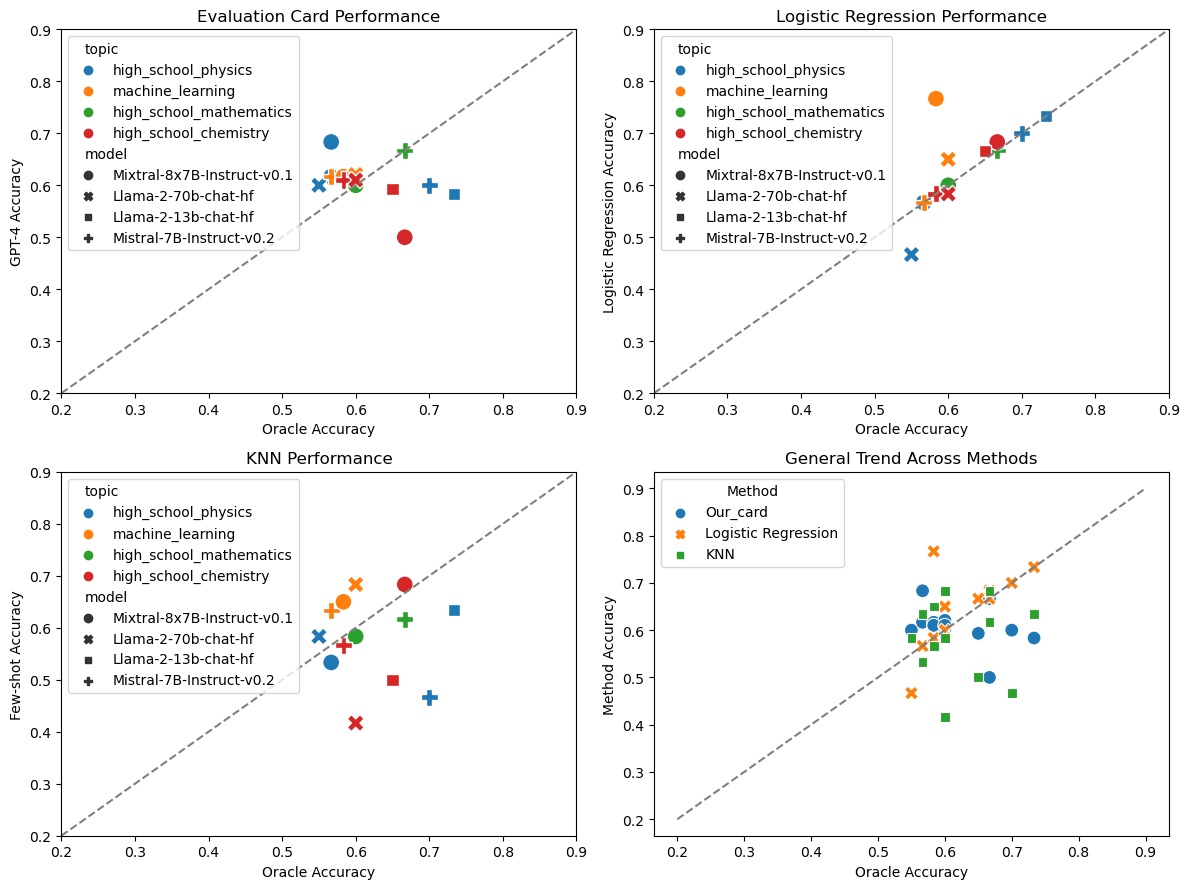

In [39]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# New limits for the plots
x_lim = y_lim = (0.2, 0.9)

# Adjusting point size
point_size = 150
#  Could not interpret value `topic` for parameter `hue`
# change the hue to model


# Scatter plot for model_acc ("GPT-4")
sns.scatterplot(ax=axs[0, 0], data=merged, x='Oracle_Accuracy', y='Predictive_Accuracy', hue='topic', style='model', s=point_size)
axs[0, 0].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[0, 0].set_title('Evaluation Card Performance')
axs[0, 0].set_xlim(x_lim)
axs[0, 0].set_ylim(y_lim)
axs[0, 0].set_xlabel('Oracle Accuracy')
axs[0, 0].set_ylabel('GPT-4 Accuracy')

# Scatter plot for Logistic Regression
sns.scatterplot(ax=axs[0, 1], data=merged, x='Oracle_Accuracy', y='logistic_reg_acc', hue='topic', style='model', s=point_size)
axs[0, 1].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[0, 1].set_title('Logistic Regression Performance')
axs[0, 1].set_xlim(x_lim)
axs[0, 1].set_ylim(y_lim)
axs[0, 1].set_xlabel('Oracle Accuracy')
axs[0, 1].set_ylabel('Logistic Regression Accuracy')

# Scatter plot for Few-shot
sns.scatterplot(ax=axs[1, 0], data=merged, x='Oracle_Accuracy', y='knn_accuracy', hue='topic', style='model', s=point_size)
axs[1, 0].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[1, 0].set_title('KNN Performance')
axs[1, 0].set_xlim(x_lim)
axs[1, 0].set_ylim(y_lim)
axs[1, 0].set_xlabel('Oracle Accuracy')
axs[1, 0].set_ylabel('Few-shot Accuracy')

# Removing the fourth subplot (as per the updated request)
# fig.delaxes(axs[1][1])  # Delete the unused fourth subplot
trend_data = pd.concat([
    merged[['Oracle_Accuracy', 'Predictive_Accuracy']].rename(columns={'Predictive_Accuracy': 'Accuracy'}).assign(Method='Our_card'),
    merged[['Oracle_Accuracy', 'logistic_reg_acc']].rename(columns={'logistic_reg_acc': 'Accuracy'}).assign(Method='Logistic Regression'),
    merged[['Oracle_Accuracy', 'knn_accuracy']].rename(columns={'knn_accuracy': 'Accuracy'}).assign(Method='KNN')
])

sns.scatterplot(ax=axs[1, 1], data=trend_data, x='Oracle_Accuracy', y='Accuracy', hue='Method', style='Method', s=100)
axs[1, 1].set_title('General Trend Across Methods')
axs[1, 1].set_xlabel('Oracle Accuracy')
axs[1, 1].set_ylabel('Method Accuracy')
axs[1, 1].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line


plt.tight_layout()
plt.show()


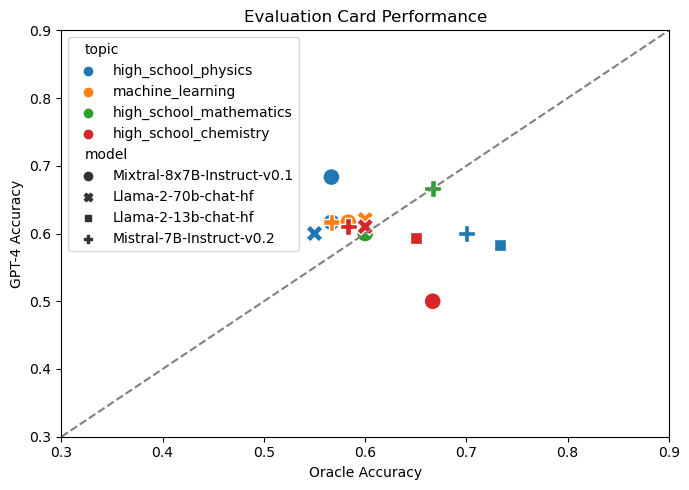

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(7, 5))

# New limits for the plots
x_lim = y_lim = (0.3, 0.9)

# Adjusting point size
point_size = 150
#  Could not interpret value `topic` for parameter `hue`
# change the hue to model


# Scatter plot for model_acc ("GPT-4")
sns.scatterplot(ax=axs, data=merged, x='Oracle_Accuracy', y='Predictive_Accuracy', hue='topic', style='model', s=point_size)
axs.plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs.set_title('Evaluation Card Performance')
axs.set_xlim(x_lim)
axs.set_ylim(y_lim)
axs.set_xlabel('Oracle Accuracy')
axs.set_ylabel('GPT-4 Accuracy')


plt.tight_layout()
plt.show()


ValueError: Could not interpret value `model_acc	` for parameter `x`

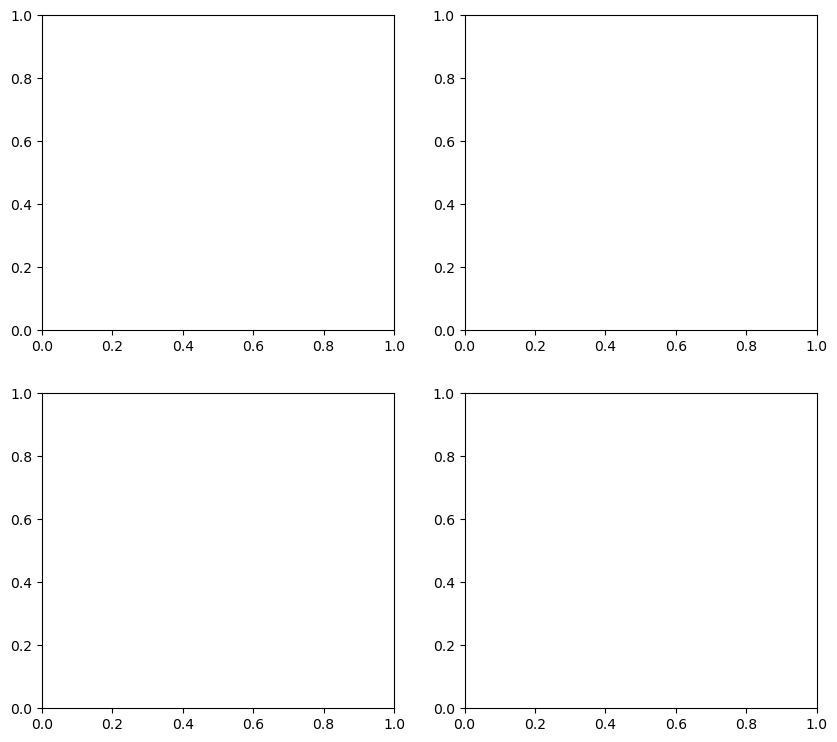

In [41]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(10, 9))

# New limits for the plots
x_lim = y_lim = (0.2, 0.9)

# Adjusting point size
point_size = 150
#  Could not interpret value `topic` for parameter `hue`
# change the hue to model


# Scatter plot for model_acc ("GPT-4")
sns.scatterplot(ax=axs[0, 0], data=merged, x='model_acc	', y='One-shot', hue='topic', style='model', s=point_size)
axs[0, 0].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[0, 0].set_title('Evaluation Card Performance')
axs[0, 0].set_xlim(x_lim)
axs[0, 0].set_ylim(y_lim)
axs[0, 0].set_xlabel('Model Accuracy')
axs[0, 0].set_ylabel('GPT-4 Accuracy')

# Scatter plot for Logistic Regression
sns.scatterplot(ax=axs[0, 1], data=merged, x='model_acc	', y='logistic_reg_acc', hue='topic', style='model', s=point_size)
axs[0, 1].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[0, 1].set_title('Logistic Regression Performance')
axs[0, 1].set_xlim(x_lim)
axs[0, 1].set_ylim(y_lim)
axs[0, 1].set_xlabel('Model Accuracy')
axs[0, 1].set_ylabel('Logistic Regression Accuracy')

# Scatter plot for Few-shot
sns.scatterplot(ax=axs[1, 0], data=merged, x='model_acc	', y='Few-shot', hue='topic', style='model', s=point_size)
axs[1, 0].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[1, 0].set_title('Few-shot Performance')
axs[1, 0].set_xlim(x_lim)
axs[1, 0].set_ylim(y_lim)
axs[1, 0].set_xlabel('Model Accuracy')
axs[1, 0].set_ylabel('Few-shot Accuracy')

# Removing the fourth subplot (as per the updated request)
# fig.delaxes(axs[1][1])  # Delete the unused fourth subplot
trend_data = pd.concat([
    merged[['model_acc	', 'One-shot']].rename(columns={'One-shot': 'Accuracy'}).assign(Method='Our_card'),
    merged[['model_acc	', 'logistic_reg_acc']].rename(columns={'logistic_reg_acc': 'Accuracy'}).assign(Method='Logistic Regression'),
    merged[['model_acc	', 'Few-shot']].rename(columns={'Few-shot': 'Accuracy'}).assign(Method='Few-shot')
])

sns.scatterplot(ax=axs[1, 1], data=trend_data, x='model_acc	', y='Accuracy', hue='Method', style='Method', s=100)
axs[1, 1].set_title('General Trend Across Methods')
axs[1, 1].set_xlabel('Oracle Accuracy')
axs[1, 1].set_ylabel('Method Accuracy')
axs[1, 1].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line


plt.tight_layout()
plt.show()


In [58]:
# save to csv
merged_df.to_csv("merged_results.csv", index=False)

In [65]:
print(merged_df.iloc[0])

topic               high_school_mathematics
model                   Llama-2-13b-chat-hf
oracle_acc                             0.77
Few-shot                               0.72
Our Eval Card                          0.77
Unnamed: 5                              NaN
topic               high_school_mathematics
model_acc                          0.233333
logistic_reg_acc                   0.766667
knn_accuracy                       0.716667
Name: 0, dtype: object


In [66]:
import seaborn as sns

In [75]:
new_file_path = "merged_results.csv"

new_data = pd.read_csv(new_file_path)

# Display the first few rows of the dataframe to understand its structure
merged_df.head()

new_data = merged_df

# drop topic.1
# new_data = new_data.drop(columns=['topic.1'])
# remove reptitive columns
new_data = new_data.loc[:,~new_data.columns.duplicated()]
# drop all unnamed
new_data = new_data.loc[:, ~new_data.columns.str.contains('^Unnamed')]
new_data.head()

,topic,model,oracle_acc,Few-shot,Our Eval Card,model_acc,logistic_reg_acc,knn_accuracy
0,high_school_mathematics,Llama-2-13b-chat-hf,0.77,0.72,0.77,0.233333,0.766667,0.716667
1,high_school_mathematics,Llama-2-70b-chat-hf,0.70,0.60,0.77,0.300000,0.700000,0.666667
2,high_school_mathematics,Mixtral-8x7B-Instruct-v0.1,0.60,0.63,0.67,0.400000,0.600000,0.583333
3,high_school_physics,Llama-2-13b-chat-hf,0.73,0.67,0.38,0.266667,0.733333,0.633333
4,high_school_physics,Llama-2-70b-chat-hf,0.55,0.45,0.62,0.450000,0.466667,0.583333


ValueError: Could not interpret value `oracle_acc` for parameter `x`

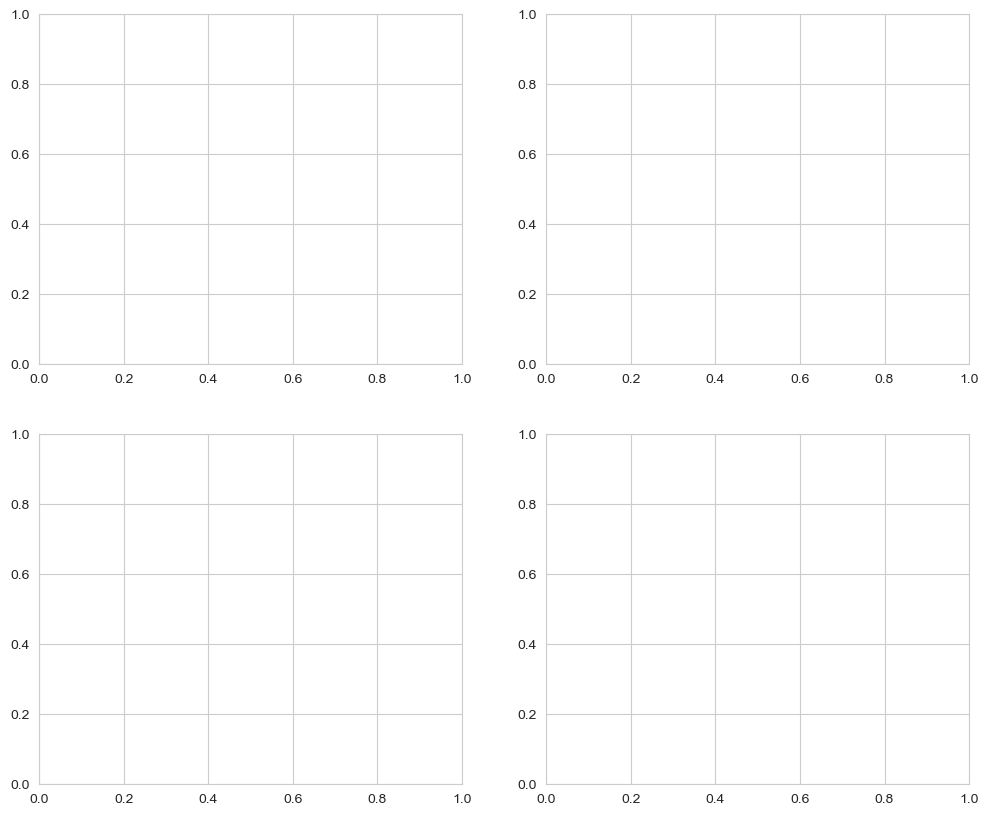

In [68]:
# Adjusting the figure size and point sizes, and setting the limits to (0, 1)

# Creating subplots with a smaller size
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# New limits for the plots
x_lim = y_lim = (0, 1)

# Adjusting point size
point_size = 150
#  Could not interpret value `topic` for parameter `hue`
# change the hue to model


# Scatter plot for model_acc ("GPT-4")
sns.scatterplot(ax=axs[0, 0], data=new_data, x='oracle_acc', y='Our Eval Card', hue='topic', style='model', s=point_size)
axs[0, 0].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[0, 0].set_title('GPT-4 Performance')
axs[0, 0].set_xlim(x_lim)
axs[0, 0].set_ylim(y_lim)
axs[0, 0].set_xlabel('Oracle Accuracy')
axs[0, 0].set_ylabel('GPT-4 Accuracy')

# Scatter plot for Logistic Regression
sns.scatterplot(ax=axs[0, 1], data=new_data, x='oracle_acc', y='logistic_reg_acc', hue='topic', style='model', s=point_size)
axs[0, 1].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[0, 1].set_title('Logistic Regression Performance')
axs[0, 1].set_xlim(x_lim)
axs[0, 1].set_ylim(y_lim)
axs[0, 1].set_xlabel('Oracle Accuracy')
axs[0, 1].set_ylabel('Logistic Regression Accuracy')

# Scatter plot for Few-shot
sns.scatterplot(ax=axs[1, 0], data=new_data, x='oracle_acc', y='Few-shot', hue='topic', style='model', s=point_size)
axs[1, 0].plot(x_lim, y_lim, linestyle='--', color='gray')  # y=x line
axs[1, 0].set_title('Few-shot Performance')
axs[1, 0].set_xlim(x_lim)
axs[1, 0].set_ylim(y_lim)
axs[1, 0].set_xlabel('Oracle Accuracy')
axs[1, 0].set_ylabel('Few-shot Accuracy')

# Removing the fourth subplot (as per the updated request)
fig.delaxes(axs[1][1])  # Delete the unused fourth subplot

plt.tight_layout()
plt.show()


In [36]:
print(new_data.shape)

(16, 8)


In [40]:
new_data = new_data.reset_index(drop=True)